In [32]:
!pip install tensorflow==2.0
!pip install unidecode

     |████████████████████████████████| 245kB 2.7MB/s 


In [5]:
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pickle
import csv
import random
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Embedding, Reshape
print(tf.__version__)


2.0.0


In [6]:
url="https://raw.githubusercontent.com/tlkh/text-emotion-classification/master/data.csv"
import urllib.request
urllib.request.urlretrieve(url, "data.csv")
sentence=[]
sentiment=[]
texts=[]
with open("data.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        texts.append(row)
print(texts[12])
random.shuffle(texts)
for row in texts:
        sentence.append(row[0])
        sentiment.append(int(row[1]))
# neutral, happy, sad, anger, hate.


['angry guy screws his gf in very rude manner', '4']


In [7]:
import tensorflow_hub as hub
embed = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1") 
embeddings = embed(sentence)
sent_array = embeddings.numpy()
print(embeddings[7])
print(embeddings.shape)


tf.Tensor(
[ 1.74663693e-01  1.25735238e-01 -1.31882504e-01 -1.35496885e-01
  2.04549998e-01 -5.44429868e-02 -8.29431636e-04 -5.44252619e-02
 -1.16643503e-01  6.64263219e-02  1.76726654e-02 -1.53267041e-01
 -1.16694711e-01  7.87114259e-03  2.01304600e-01 -7.60124549e-02
  1.21336810e-01 -1.14849269e-01  9.65951830e-02 -7.27390349e-02
 -4.25060000e-03 -6.11165278e-02  1.44659624e-01  2.48515955e-03
 -4.15436216e-02 -3.90710197e-02 -4.68453951e-02  6.70969933e-02
 -1.56221181e-01 -8.35357383e-02 -2.81427931e-02  5.33469282e-02
  7.15962844e-03 -1.31630688e-04  1.21250153e-01 -9.50673893e-02
 -8.39619339e-02 -7.97251463e-02 -1.08090742e-02  9.56058875e-02
 -2.74046332e-01 -1.75905198e-01  5.54327443e-02  1.44193798e-01
  1.12006105e-01 -1.14120334e-01  8.17512125e-02  1.28041161e-02
  1.38821036e-01  1.46573201e-01 -8.50224309e-03 -1.88676223e-01
 -4.26060408e-02  1.06746413e-01 -1.05338275e-01 -8.73125792e-02
  5.12859896e-02 -1.35774285e-01 -4.23440188e-02  1.73015110e-02
  5.79181463e-

In [55]:
import tensorflow_datasets as tfds
import unidecode
token =  tfds.features.text.Tokenizer()
vocab = [token.tokenize(x) for x in sentence]
vocab = list(set([y for x in vocab for y in x]))
encoder = tfds.features.text.SubwordTextEncoder(vocab_list=vocab)
X_train = np.array([encoder.encode(x) for x in sentence])
print(X_train.shape)
print(X_train[:5])
print(len(np.unique(X_train)))

(47288,)
[list([17451, 34393, 4310, 34393, 14548, 34393, 2129, 34393, 1036, 34393, 16715, 34393, 16715, 34393, 33676, 34393, 18783, 34393, 10853, 34393, 26766, 34393, 16568, 34393, 10853, 34393, 12789, 34393, 10853, 34393, 6769, 34393, 17889])
 list([28635, 34393, 19463, 34393, 32249, 34393, 26545, 34393, 21314, 34393, 32646, 34393, 13243, 34393, 17930, 34393, 24613, 34393, 782, 34393, 21927, 34393, 912, 34393, 10484, 34393, 32869, 34393, 24468, 34393, 11971, 34393, 12521, 34393, 7916, 34393, 14183, 34393, 21789, 34393, 11049, 34393, 10484, 34393, 22411, 34393, 18790, 34393, 14798])
 list([26545, 34393, 24613, 34393, 543, 34393, 15297, 34393, 33812, 34393, 5998, 34393, 15297, 34393, 9243, 34393, 24055, 34393, 10570, 34393, 19271, 34393, 20341, 34393, 30956, 34393, 4416, 34393, 22728, 34393, 395])
 list([26545, 34393, 25826, 34393, 30841, 34393, 6110, 34393, 1371, 34393, 30956, 34393, 22267, 34393, 21559, 34393, 26227, 34393, 13827, 34393, 18165, 34393, 16180, 34393, 32919, 34393, 15297

In [80]:
from tensorflow.keras.preprocessing import sequence
X_train = sequence.pad_sequences(X_train, maxlen=80)
max_features = 50000

tf.keras.backend.clear_session()  # For easy reset of notebook state.

model = Sequential()
model.add(Embedding(max_features, 128))
#model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1", output_shape=[50], input_shape=[], dtype=tf.string, trainable=True))
#model.add(Reshape(target_shape=(128, 1)))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model.fit(X_train, np.array(sentiment), batch_size=128, epochs=5, validation_split=0.3, verbose=1)

Train on 33101 samples, validate on 14187 samples
Epoch 1/5
33101/33101 [==============================] - 84s 3ms/sample - loss: 1.1039 - accuracy: 0.5175 - val_loss: 0.9850 - val_accuracy: 0.5825
Epoch 2/5
33101/33101 [==============================] - 81s 2ms/sample - loss: 0.8293 - accuracy: 0.6746 - val_loss: 1.0138 - val_accuracy: 0.5769
Epoch 3/5
33101/33101 [==============================] - 81s 2ms/sample - loss: 0.5916 - accuracy: 0.7784 - val_loss: 1.1593 - val_accuracy: 0.5633
Epoch 4/5
33101/33101 [==============================] - 82s 2ms/sample - loss: 0.4459 - accuracy: 0.8305 - val_loss: 1.3369 - val_accuracy: 0.5564
Epoch 5/5
33101/33101 [==============================] - 82s 2ms/sample - loss: 0.3613 - accuracy: 0.8624 - val_loss: 1.5263 - val_accuracy: 0.5522


In [84]:
output = ["neutral", "happy", "sad", "anger", "hate"]
print("i m still working",output[np.argmax(model.predict(sequence.pad_sequences([encoder.encode("i m still working")])))])
print("my computer is slow",output[np.argmax(model.predict(sequence.pad_sequences([encoder.encode("my computer is slow")])))])
print("fuck you",output[np.argmax(model.predict(sequence.pad_sequences([encoder.encode("fuck you")])))])
print("shit",output[np.argmax(model.predict(sequence.pad_sequences([encoder.encode("shit")])))])
print("i am busy",output[np.argmax(model.predict(sequence.pad_sequences([encoder.encode("i am busy")])))])


i m still working sad
my computer is slow sad
fuck you anger
shit sad
i am busy sad


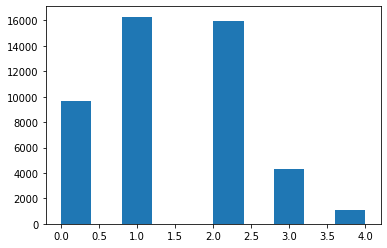

In [83]:
import matplotlib.pyplot as plt
plt.hist(np.array(sentiment))
plt.show()